In [1]:
import numpy as np
import pandas as pd
import gudhi as gd
import sys
import matplotlib.pyplot as plt
import networkx as nx
from ripser import Rips
import pickle
import os
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import svds
from scipy.linalg import eigh
import numpy as np

/home/zluo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Graph:
    # Constructor
    def __init__(self, edges, n):
 
        # A list of lists to represent an adjacency list
        self.adjList = [[] for _ in range(n)]
 
        # add edges to the directed graph
        for (source, dest, weight) in edges:
            self.adjList[source].append((dest, weight))
 
 
# Perform DFS on the graph and set the departure time of all
# vertices of the graph
def DFS(graph, v, discovered, departure, time):
    # mark the current node as discovered
    discovered[v] = True
 
    # set arrival time – not needed
    # time = time + 1
 
    # do for every edge (v, u)
    for (u, w) in graph.adjList[v]:
        # if `u` is not yet discovered
        if not discovered[u]:
            time = DFS(graph, u, discovered, departure, time)
 
    # ready to backtrack
    # set departure time of vertex `v`
    departure[time] = v
    time = time + 1
 
    return time
 
def findLongestDistance(graph, source, n):
    # `departure` stores vertex number having its departure
    # time equal to the index of it
    departure = [-1] * n
 
    # to keep track of whether a vertex is discovered or not
    discovered = [False] * n
    time = 0
 
    # perform DFS on all undiscovered vertices
    for i in range(n):
        if not discovered[i]:
            time = DFS(graph, i, discovered, departure, time)
 
    cost = [sys.maxsize] * n
    cost[source] = 0
 
    # Process the vertices in topological order, i.e., in order
    # of their decreasing departure time in DFS
    for i in reversed(range(n)):
 
        # for each vertex in topological order,
        # relax the cost of its adjacent vertices
        v = departure[i]
 
        # edge from `v` to `u` having weight `w`
        for (u, w) in graph.adjList[v]:
            w = -w     # make edge weight negative
 
            # if the distance to destination `u` can be shortened by
            # taking edge (v, u), then update cost to the new lower value
            if cost[v] != sys.maxsize and cost[v] + w < cost[u]:
                cost[u] = cost[v] + w
 
    dist = dict()
    for i in range(n):
        dist[i] = {-cost[i]}
        
    return dist

In [ ]:
col = col_row[0]
row = col_row[1]
edgs = np.array([col, row]).T
all_dist_raw = []
edgs_d = [(lst[0], lst[1], 1) for lst in edgs] 
n = len(np.unique(row + col))
graph = Graph(edgs_d, n)
for node in p_input: all_dist_raw.append(findLongestDistance(graph, node, n))

# building the delay based dictionary
delay_dict = all_dist_raw[0]
delay_dict = {key: list(delay_dict[key]) for key in delay_dict.keys()}
for dist in all_dist_raw[1:]:
    for key in dist.keys(): 
        val = dist[key]
        if key in delay_dict.keys():
            delay_dict[key] = delay_dict[key] + list(val)
        else:
            delay_dict[key] = list(val)

delay_dict = {key: max(delay_dict[key]) for key in delay_dict.keys()}

In [3]:
def d_eff(i, j):
    eig_values = eig_all[0]
    eig_vectors = eig_all[1]
    
    d_eff_2 = 0
    for idx in range(len(eig_values)):
        eig_value = np.real(eig_values[idx])
        eig_vector = eig_vectors[:, idx]
        if np.isclose(eig_value, 0):
            continue
        d_eff_2 += (1/eig_value)*((eig_vector[i] - eig_vector[j])**2)

    return np.real(d_eff_2**(1/2))

In [36]:
#Test on several examples
#example1:
col_row = np.array([[1, 4], [1, 5], [2, 6], [2, 9], [3, 6], [4, 8], [4, 7], [5, 9], [8, 10], [9, 10], [6, 10]])
col_row = col_row.T
###
col_row = col_row - 1

In [19]:
#example2:
col_row = np.array([[0, 1], [0, 2], [1, 3], [1, 4], [2, 6], [4, 5], [4, 6], [6, 5], [5, 7]])
col_row = col_row.T

In [39]:
#example3:
col_row = np.array([[0, 1], [0, 2], [1, 3], [1, 4], [2, 3], [2, 5], [3, 8], [5, 9], [3, 7], [4, 7], [4, 6], [8, 10], [10, 11], [9, 11]])
col_row = col_row.T

In [42]:
#example4:
col_row = np.array([[0, 1], [0, 2], [1, 3], [3, 4], [4, 5], [6, 2]])
col_row = col_row.T

In [5]:
col_row

array([[0, 0, 1, 1, 2, 3, 3, 4, 7, 8, 5],
       [3, 4, 5, 8, 5, 7, 6, 8, 9, 9, 9]])

In [43]:
# Building the Graph (undirected)
edgelist = []
for edge in col_row.T:
    new_edge = (edge[0], edge[1])
    edgelist.append(new_edge)
    
G = nx.DiGraph(edgelist)
V = list(G.nodes())
nodelist = [node for node in G.nodes]
nodelist = sorted(nodelist)
adj = nx.adjacency_matrix(G, nodelist=nodelist)

idx_dict = {}
for idx in range(len(nodelist)):
    idx_dict[nodelist[idx]] = idx
    
global L
L = csgraph.laplacian(adj)
#example
L = L.todense()
w, v = eigh(L)

global eig_all
eig_all = (w, v)

eig_v = [(np.real(w[idx]), v[idx]) for idx in range(len(w))]
eig_v.sort(key = lambda x:x[0])

x = [idx for idx in range(len(w))]
y = [np.real(val[0]) for val in eig_v]

p_input = []
p_output = []
col = col_row[0]
row = col_row[1]

for node in col:
    if node not in row:
        p_input.append(node)

for node in row:
    if node not in col:
        p_output.append(node)
        
p_input = np.unique(np.array(p_input))
p_output = np.unique(np.array(p_output))

#####################################
nn = sub_g.number_of_nodes()
idx_dict = {list(sub_g.nodes)[idx]:idx for idx in range(nn)}
all_dist_raw = []
edgs_d = [(idx_dict[lst[0]], idx_dict[lst[1]], 1) for lst in edgs] 
n = nn
graph = Graph(edgs_d, n)

if len(p_input) == 1:
    delay_dict = findLongestDistance(graph, idx_dict[s_n], n)
    delay_dict = {key: delay_dict[key].pop() for key in delay_dict.keys()}

else:
    for node in p_input: all_dist_raw.append(findLongestDistance(graph, idx_dict[node], n))

    # building the delay based dictionary
    delay_dict = all_dist_raw[0]
    delay_dict = {key: list(delay_dict[key]) for key in delay_dict.keys()}
    for dist in all_dist_raw[1:]:
        for key in dist.keys(): 
            val = dist[key]
            if key in delay_dict.keys():
                delay_dict[key] = delay_dict[key] + list(val)
            else:
                delay_dict[key] = list(val)

    delay_dict = {key: max(delay_dict[key]) for key in delay_dict.keys()}
##########################################
d_lst = []
for delay in range(max(delay_dict.values()) + 1):
    delay_level_lst = []
    for node in delay_dict.keys():
        if delay_dict[node] == delay:
            delay_level_lst.append(node)
    
    if len(delay_level_lst) == 0:
        continue
    d_lst.append(delay_level_lst)

st = gd.SimplexTree()
edgs = edgelist
to_level = len(d_lst) # read the graph to a specific delay level

for edg in edgs:
    st.insert(edg)

for delay in range(to_level):
    nodes = d_lst[delay]
    for node in nodes:
        st.assign_filtration([node], delay)
        
st.extend_filtration()
dgms = st.extended_persistence()

In [ ]:
er_new_dict = {}
for v1 in V:
    for v2 in V:
        if v1 == v2:
            continue
        er_new_dict[(v1, v2)] = nx.resistance_distance(G, v1, v2)
        

er_edge_dict = {}
for edge in edgelist:
    er_edge_dict[edge] = nx.resistance_distance(G, edge[0], edge[1])

In [ ]:
#Don't touch
edgs = np.array([col, row]).T
all_dist_raw = []
edgs_d = [(lst[0], lst[1], 1) for lst in edgs] 
n = len(G.nodes)
graph = Graph(edgs_d, n)
for node in p_input: all_dist_raw.append(findLongestDistance(graph, node, n))

# building the delay based dictionary
delay_dict = all_dist_raw[0]
delay_dict = {key: list(delay_dict[key]) for key in delay_dict.keys()}
for dist in all_dist_raw[1:]:
    for key in dist.keys(): 
        val = dist[key]
        if key in delay_dict.keys():
            delay_dict[key] = delay_dict[key] + list(val)
        else:
            delay_dict[key] = list(val)

delay_dict = {key: max(delay_dict[key]) for key in delay_dict.keys()}


In [33]:
all_dist_raw

[{0: 0, 1: 1, 3: 2, 4: 2, 5: 4, 7: 4, 6: 3, 2: 1}]

In [34]:
delay_dict

{0: 0, 1: 1, 3: 2, 4: 2, 5: 4, 7: 4, 6: 3, 2: 1}

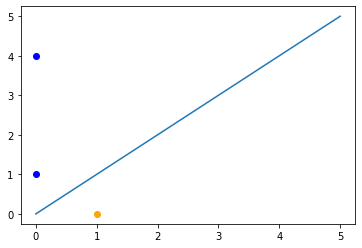

In [44]:
plt.scatter([dgms[0][i][1][0] for i in range(len(dgms[0]))], [dgms[0][i][1][1] for i in range(len(dgms[0]))], color="blue")
plt.scatter([dgms[2][i][1][0] for i in range(len(dgms[2]))], [dgms[2][i][1][1] for i in range(len(dgms[2]))], color="blue")
plt.scatter([dgms[1][i][1][0] for i in range(len(dgms[1]))], [dgms[1][i][1][1] for i in range(len(dgms[1]))], color="orange")
plt.scatter([dgms[3][i][1][0] for i in range(len(dgms[3]))], [dgms[3][i][1][1] for i in range(len(dgms[3]))], color="orange")
plt.plot([0, to_level],[0,to_level])

In [10]:
dgms

[[(0, (0.0, 1.9999999999999996))],
 [(1, (1.9999999999999996, 0.9999999999999998)),
  (1, (1.9999999999999996, 0.9999999999999998))],
 [(0, (0.0, 3.0))],
 [(1, (3.0, 0.0)), (1, (3.0, 0.0))]]

In [16]:
L

matrix([[ 2,  0,  0, -1, -1,  0,  0,  0,  0,  0],
        [ 0,  2,  0,  0,  0, -1,  0,  0, -1,  0],
        [ 0,  0,  1,  0,  0, -1,  0,  0,  0,  0],
        [-1,  0,  0,  3,  0,  0, -1, -1,  0,  0],
        [-1,  0,  0,  0,  2,  0,  0,  0, -1,  0],
        [ 0, -1, -1,  0,  0,  3,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0, -1,  0,  0,  0,  2,  0, -1],
        [ 0, -1,  0,  0, -1,  0,  0,  0,  3, -1],
        [ 0,  0,  0,  0,  0, -1,  0, -1, -1,  3]])

In [8]:
er_new_dict

{(0, 3): 0.8260869565217384,
 (0, 4): 0.8260869565217389,
 (0, 1): 1.869565217391303,
 (0, 5): 1.9130434782608685,
 (0, 8): 1.304347826086956,
 (0, 2): 2.9130434782608683,
 (0, 7): 1.3043478260869554,
 (0, 6): 1.8260869565217388,
 (0, 9): 1.4347826086956517,
 (3, 0): 0.8260869565217389,
 (3, 4): 1.304347826086957,
 (3, 1): 1.9130434782608694,
 (3, 5): 1.8695652173913049,
 (3, 8): 1.4347826086956519,
 (3, 2): 2.8695652173913038,
 (3, 7): 0.826086956521739,
 (3, 6): 1.0000000000000002,
 (3, 9): 1.3043478260869565,
 (4, 0): 0.8260869565217392,
 (4, 3): 1.3043478260869568,
 (4, 1): 1.478260869565218,
 (4, 5): 1.6086956521739126,
 (4, 8): 0.826086956521739,
 (4, 2): 2.608695652173913,
 (4, 7): 1.4347826086956526,
 (4, 6): 2.3043478260869565,
 (4, 9): 1.2173913043478262,
 (1, 0): 1.869565217391303,
 (1, 3): 1.9130434782608683,
 (1, 4): 1.4782608695652169,
 (1, 5): 0.7391304347826082,
 (1, 8): 0.7391304347826084,
 (1, 2): 1.7391304347826084,
 (1, 7): 1.6086956521739126,
 (1, 6): 2.91304347826

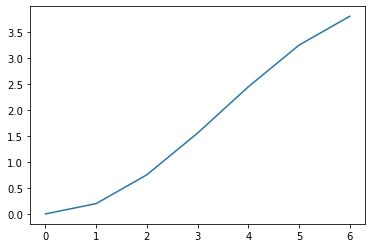

In [19]:
plt.plot(x, y)